In [8]:
!pip install torch torchvision torchaudio

✅ Dataset successfully split into train, val, and test sets!
Using device: cpu
Classes: ['Normal', 'Stroke']
Training Distribution: Counter({0: 1551, 1: 950})


C:\Users\zahja\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training ResNet18 on Brain Stroke Dataset...
Epoch [1/50] Loss: 0.9867 Train Acc: 67.21% Val Acc: 77.74%
Epoch [2/50] Loss: 0.8365 Train Acc: 74.05% Val Acc: 79.73%
Epoch [3/50] Loss: 0.9396 Train Acc: 78.65% Val Acc: 84.39%
Epoch [4/50] Loss: 1.0204 Train Acc: 81.97% Val Acc: 83.72%
Epoch [5/50] Loss: 0.6514 Train Acc: 82.37% Val Acc: 90.03%
Epoch [6/50] Loss: 0.5118 Train Acc: 85.33% Val Acc: 90.37%
Epoch [7/50] Loss: 0.2240 Train Acc: 86.25% Val Acc: 93.36%
Epoch [8/50] Loss: 0.2922 Train Acc: 88.16% Val Acc: 95.68%
Epoch [9/50] Loss: 0.3236 Train Acc: 88.40% Val Acc: 91.03%
Epoch [10/50] Loss: 1.5434 Train Acc: 90.36% Val Acc: 85.38%
Epoch [11/50] Loss: 0.0827 Train Acc: 91.84% Val Acc: 90.03%
Epoch [12/50] Loss: 0.2750 Train Acc: 91.84% Val Acc: 92.69%
Epoch [13/50] Loss: 0.1100 Train Acc: 93.92% Val Acc: 98.34%
Epoch [14/50] Loss: 0.0299 Train Acc: 94.92% Val Acc: 95.68%
Epoch [15/50] Loss: 0.3852 Train Acc: 95.24% Val Acc: 97.67%
Epoch [16/50] Loss: 0.1741 Train Acc: 95.08% Val 

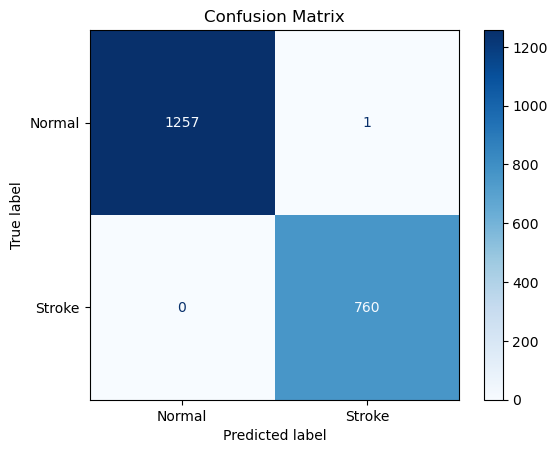

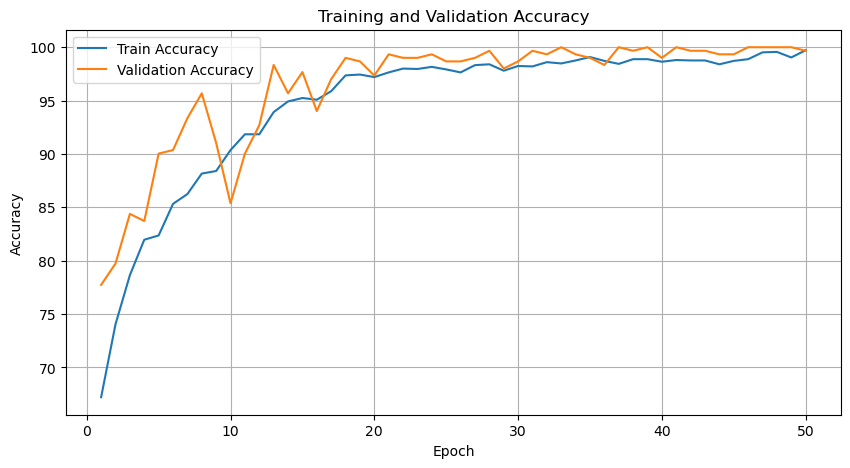

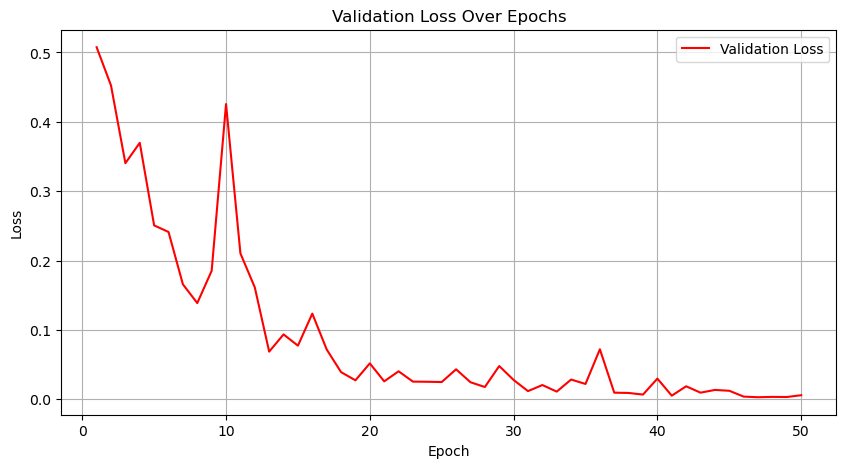

ModuleNotFoundError: No module named 'cv2'

In [3]:
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# ============================
# 1. Split Dataset into Train/Val/Test
# ============================
def split_dataset(dataset_path, output_path, train_ratio=0.8, val_ratio=0.1):
    categories = ["Stroke", "Normal"]
    train_dir = os.path.join(output_path, "train")
    val_dir = os.path.join(output_path, "val")
    test_dir = os.path.join(output_path, "test")

    for category in categories:
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path):
            print(f"❌ Error: Category folder not found - {category_path}")
            continue

        images = os.listdir(category_path)
        random.shuffle(images)
        total = len(images)
        train_split = int(total * train_ratio)
        val_split = int(total * (train_ratio + val_ratio))

        train_images = images[:train_split]
        val_images = images[train_split:val_split]
        test_images = images[val_split:]

        for img in train_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category, img))
        for img in val_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category, img))
        for img in test_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(test_dir, category, img))

    print("✅ Dataset successfully split into train, val, and test sets!")

# Define dataset paths
dataset_path = os.path.abspath("dataset")
output_path = os.path.abspath("split_dataset")
split_dataset(dataset_path, output_path)

# ============================
# 2. Check GPU Availability
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# 3. Set Hyperparameters
# ============================
EPOCHS = 50
BATCH_SIZE = 16
LR = 1e-4
WEIGHT_DECAY = 1e-5

# ============================
# 4. Prepare Dataset & Preprocessing
# ============================
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(10, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_eval = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(root=os.path.join(output_path, "train"), transform=transform_train)
val_dataset = datasets.ImageFolder(root=os.path.join(output_path, "val"), transform=transform_eval)
test_dataset = datasets.ImageFolder(root=os.path.join(output_path, "test"), transform=transform_eval)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = train_dataset.classes
print(f"Classes: {class_names}")
train_counts = Counter(train_dataset.targets)
print(f"Training Distribution: {train_counts}")

# ============================
# 5. Define ResNet-18 Model
# ============================
class ResNet(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(ResNet, self).__init__()
        from torchvision.models import resnet18, ResNet18_Weights
        weights = ResNet18_Weights.DEFAULT if pretrained else None
        self.model = resnet18(weights=weights)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.model(x)

net = ResNet(num_classes=2).to(device)

# ============================
# 6. Load Model & Set Optimizer
# ============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# ============================
# 7. Train the Model
# ============================
print("Training ResNet18 on Brain Stroke Dataset...")
best_val_acc = 0.0
train_accuracies, val_accuracies, val_losses = [], [], []

for epoch in range(EPOCHS):
    net.train()
    correct, total, running_loss = 0, 0, 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc = 100 * correct / total
    train_accuracies.append(train_acc)

    net.eval()
    val_correct, val_total, val_running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total
    val_loss = val_running_loss / len(val_loader)
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {loss.item():.4f} Train Acc: {train_acc:.2f}% Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(net.state_dict(), "best_stroke_detection_resnet18.pth")

print(f"✅ Training Complete. Best Validation Accuracy: {best_val_acc:.2f}%")

# ============================
# 8. Evaluate the Model
# ============================
print("Evaluating Model...")
net.load_state_dict(torch.load("best_stroke_detection_resnet18.pth"))
net.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification Report and Confusion Matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=1))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ============================
# 9. Plot Metrics
# ============================
epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

#_________________

from sklearn.metrics import roc_auc_score, roc_curve, auc
import cv2
import torchvision.models as models
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# ============================
# 10. AUC-ROC Score
# ============================
print("\nComputing AUC-ROC score...")
y_prob = []
net.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = net(images)
        probs = F.softmax(outputs, dim=1)[:, 1]  # Probability of class 'Stroke'
        y_prob.extend(probs.cpu().numpy())

roc_auc = roc_auc_score(y_true, y_prob)
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ============================
# 11. Grad-CAM Visualization
# ============================
print("\nGenerating Grad-CAM visualization...")
from torchvision.models.feature_extraction import create_feature_extractor

# Extract features from last conv layer
feature_layers = {'layer4': 'feat'}
model_with_features = create_feature_extractor(net.model, return_nodes=feature_layers)
model_with_features.eval()

# Pick one image from the test set
for test_img, label in test_dataset:
    img_tensor = test_img.unsqueeze(0).to(device)
    break

# Forward pass with feature extraction
with torch.no_grad():
    features = model_with_features(img_tensor)
    output = net(img_tensor)
    pred_class = output.argmax(dim=1).item()

# Get gradients
img_tensor.requires_grad_()
features = model_with_features(img_tensor)
out = net(img_tensor)
out[0, pred_class].backward()
gradients = img_tensor.grad[0]

# Use ReLU of average pooled gradients as weights
weights = gradients.mean(dim=(1, 2), keepdim=True)
cam = torch.sum(weights * features['feat'][0], dim=0)
cam = torch.relu(cam)
cam = cam.cpu().numpy()
cam = cv2.resize(cam, (224, 224))
cam = cam - np.min(cam)
cam = cam / np.max(cam)

# Convert image to numpy
original_img = test_img.squeeze().numpy()
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
original_img_rgb = cv2.cvtColor(np.uint8(255 * original_img), cv2.COLOR_GRAY2BGR)
overlayed = cv2.addWeighted(original_img_rgb, 0.5, heatmap, 0.5, 0)

plt.figure(figsize=(6, 6))
plt.imshow(overlayed[..., ::-1])
plt.title(f"Grad-CAM Visualization - Predicted: {class_names[pred_class]}")
plt.axis('off')
plt.show()


In [7]:
!pip install pydicom opencv-python torch torchvision torchaudio tqdm
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension install --py widgetsnbextension --sys-prefix

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run script server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
  

✅ Dataset split complete.
Training ResNet-18 on DICOM data...


Epoch 1/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 99/99 [01:48<00:00,  1.10s/it]


Epoch 1/10: ✅ Train Acc: 60.16% | ✅ Val Acc: 61.01%


Epoch 2/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 99/99 [00:56<00:00,  1.75it/s]


Epoch 2/10: ✅ Train Acc: 63.72% | ✅ Val Acc: 65.38%


Epoch 3/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 99/99 [00:54<00:00,  1.82it/s]


Epoch 3/10: ✅ Train Acc: 65.93% | ✅ Val Acc: 68.04%


Epoch 4/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 99/99 [00:54<00:00,  1.83it/s]


Epoch 4/10: ✅ Train Acc: 67.91% | ✅ Val Acc: 72.47%


Epoch 5/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 99/99 [01:00<00:00,  1.64it/s]


Epoch 5/10: ✅ Train Acc: 70.23% | ✅ Val Acc: 71.90%


Epoch 6/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 99/99 [01:36<00:00,  1.03it/s]


Epoch 6/10: ✅ Train Acc: 71.73% | ✅ Val Acc: 77.03%


Epoch 7/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 99/99 [01:28<00:00,  1.12it/s]


Epoch 7/10: ✅ Train Acc: 75.51% | ✅ Val Acc: 78.73%


Epoch 8/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 99/99 [01:15<00:00,  1.31it/s]


Epoch 8/10: ✅ Train Acc: 77.97% | ✅ Val Acc: 79.49%


Epoch 9/10 [Val]: 100%|████████████████████████████████████████████████████████████████| 99/99 [00:53<00:00,  1.84it/s]


Epoch 9/10: ✅ Train Acc: 80.55% | ✅ Val Acc: 75.51%


Epoch 10/10 [Val]: 100%|███████████████████████████████████████████████████████████████| 99/99 [00:55<00:00,  1.79it/s]


Epoch 10/10: ✅ Train Acc: 82.09% | ✅ Val Acc: 81.65%
✅ Training complete. Best validation accuracy: 81.65%

Classification Report:
              precision    recall  f1-score   support

      Normal       0.76      0.78      0.77       628
      Stroke       0.85      0.84      0.85       952

    accuracy                           0.82      1580
   macro avg       0.81      0.81      0.81      1580
weighted avg       0.82      0.82      0.82      1580



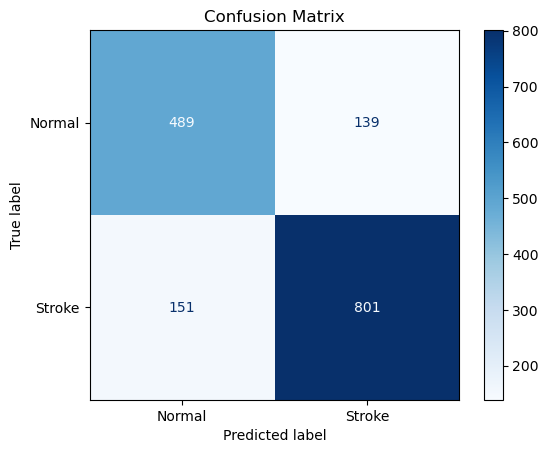

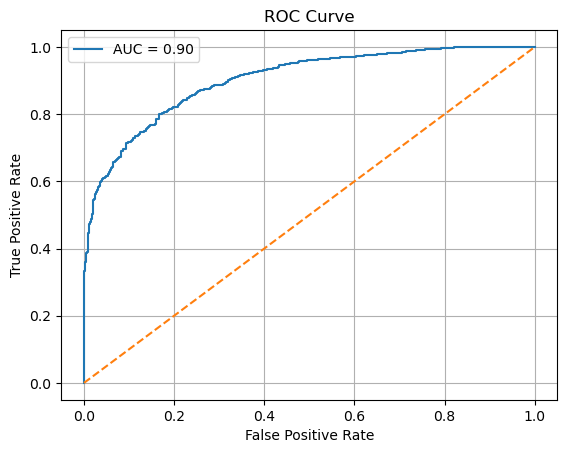

In [9]:
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pydicom
import cv2
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm import tqdm # Updated for Jupyter compatibility
# ============================
# 1. Dataset Splitter
# ============================
def split_dataset(dataset_path, output_path, train_ratio=0.8, val_ratio=0.1):
    categories = ["Stroke", "Normal"]
    for split in ["train", "val", "test"]:
        for category in categories:
            os.makedirs(os.path.join(output_path, split, category), exist_ok=True)

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path):
            print(f"❌ Error: Missing folder - {category_path}")
            continue
        images = [f for f in os.listdir(category_path) if f.endswith(".dcm")]
        random.shuffle(images)
        total = len(images)
        train_end = int(total * train_ratio)
        val_end = int(total * (train_ratio + val_ratio))
        splits = {
            "train": images[:train_end],
            "val": images[train_end:val_end],
            "test": images[val_end:]
        }
        for split, files in splits.items():
            for f in files:
                shutil.copy(os.path.join(category_path, f), os.path.join(output_path, split, category, f))
    print("✅ Dataset split complete.")

# ============================
# 2. DICOM Dataset Loader
# ============================
class DICOMDataset(Dataset):
    def __init__(self, root_dir, transform=None):  # <-- fix __init__
        self.samples = []
        self.transform = transform
        self.class_to_idx = {"Normal": 0, "Stroke": 1}
        for label in self.class_to_idx:
            class_dir = os.path.join(root_dir, label)
            for fname in os.listdir(class_dir):
                if fname.endswith(".dcm"):
                    self.samples.append((os.path.join(class_dir, fname), self.class_to_idx[label]))

    def __len__(self):  # <-- fix __len__
        return len(self.samples)

    def __getitem__(self, idx):  # <-- fix __getitem__
        path, label = self.samples[idx]
        try:
            dicom = pydicom.dcmread(path)
            img = dicom.pixel_array
            img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
            img = Image.fromarray(img).convert("L")
        except Exception as e:
            print(f"Error reading {path}: {e}")
            img = Image.fromarray(np.zeros((224, 224), dtype='uint8'))
        if self.transform:
            img = self.transform(img)
        return img, label


# ============================
# 3. Paths and Constants
# ============================
dataset_path = "dataset_2"
output_path = "split_dataset"
split_dataset(dataset_path, output_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10
BATCH_SIZE = 16
LR = 1e-4
WEIGHT_DECAY = 1e-5
class_names = ["Normal", "Stroke"]

# ============================
# 4. Transforms
# ============================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(10, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ============================
# 5. Dataloaders
# ============================
train_dataset = DICOMDataset(root_dir=os.path.join(output_path, "train"), transform=transform_train)
val_dataset = DICOMDataset(root_dir=os.path.join(output_path, "val"), transform=transform_eval)
test_dataset = DICOMDataset(root_dir=os.path.join(output_path, "test"), transform=transform_eval)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ============================
# 6. ResNet-18 Model
# ============================
class ResNet(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):  # ✅ fix here
        super(ResNet, self).__init__()                    # ✅ and here
        from torchvision.models import resnet18, ResNet18_Weights
        weights = ResNet18_Weights.DEFAULT if pretrained else None
        self.model = resnet18(weights=weights)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

net = ResNet().to(device)

# ============================
# 7. Training Setup
# ============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

train_accuracies, val_accuracies, val_losses = [], [], []
best_val_acc = 0.0

# ============================
# 8. Training Loop with Progress Bar
# ============================
print("Training ResNet-18 on DICOM data...")
for epoch in range(EPOCHS):
    net.train()
    total, correct, running_loss = 0, 0, 0.0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        train_loop.set_postfix(loss=running_loss / total, acc=100 * correct / total)

    train_acc = 100 * correct / total
    train_accuracies.append(train_acc)

    net.eval()
    val_correct, val_total, val_loss = 0, 0, 0.0
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}: ✅ Train Acc: {train_acc:.2f}% | ✅ Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(net.state_dict(), "best_stroke_detection_resnet18.pth")

print(f"✅ Training complete. Best validation accuracy: {best_val_acc:.2f}%")

# ============================
# 9. Evaluation
# ============================
net.load_state_dict(torch.load("best_stroke_detection_resnet18.pth"))
net.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = net(images)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_prob.extend(probs[:, 1].cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ============================
# 10. AUC-ROC
# ============================
roc_auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

✅ Dataset split complete.
Training ResNet-18 on DICOM data...


Epoch 1/25 [Val]: 100%|██████████████████████████████████████████████████████████████| 189/189 [02:23<00:00,  1.31it/s]


Epoch 1/25: ✅ Train Acc: 59.26% | ✅ Val Acc: 63.68%


Epoch 2/25 [Val]: 100%|██████████████████████████████████████████████████████████████| 189/189 [01:47<00:00,  1.76it/s]


Epoch 2/25: ✅ Train Acc: 63.51% | ✅ Val Acc: 64.04%


Epoch 3/25 [Val]: 100%|██████████████████████████████████████████████████████████████| 189/189 [01:45<00:00,  1.79it/s]


Epoch 3/25: ✅ Train Acc: 65.84% | ✅ Val Acc: 68.69%


Epoch 4/25 [Val]: 100%|██████████████████████████████████████████████████████████████| 189/189 [01:45<00:00,  1.79it/s]


Epoch 4/25: ✅ Train Acc: 69.14% | ✅ Val Acc: 67.70%
⏸️ No improvement for 1 epoch(s).


Epoch 5/25 [Val]: 100%|██████████████████████████████████████████████████████████████| 189/189 [01:47<00:00,  1.77it/s]


Epoch 5/25: ✅ Train Acc: 72.28% | ✅ Val Acc: 77.66%


Epoch 6/25 [Val]: 100%|██████████████████████████████████████████████████████████████| 189/189 [01:47<00:00,  1.76it/s]


Epoch 6/25: ✅ Train Acc: 74.92% | ✅ Val Acc: 79.35%


Epoch 7/25 [Val]: 100%|██████████████████████████████████████████████████████████████| 189/189 [01:46<00:00,  1.78it/s]


Epoch 7/25: ✅ Train Acc: 78.21% | ✅ Val Acc: 83.63%


Epoch 8/25 [Val]: 100%|██████████████████████████████████████████████████████████████| 189/189 [01:45<00:00,  1.78it/s]


Epoch 8/25: ✅ Train Acc: 80.66% | ✅ Val Acc: 86.65%


Epoch 9/25 [Val]: 100%|██████████████████████████████████████████████████████████████| 189/189 [01:48<00:00,  1.74it/s]


Epoch 9/25: ✅ Train Acc: 83.37% | ✅ Val Acc: 89.51%


Epoch 10/25 [Val]: 100%|█████████████████████████████████████████████████████████████| 189/189 [01:47<00:00,  1.76it/s]


Epoch 10/25: ✅ Train Acc: 84.72% | ✅ Val Acc: 88.98%


Epoch 11/25 [Val]: 100%|█████████████████████████████████████████████████████████████| 189/189 [01:51<00:00,  1.70it/s]


Epoch 11/25: ✅ Train Acc: 86.31% | ✅ Val Acc: 91.83%


Epoch 12/25 [Val]: 100%|█████████████████████████████████████████████████████████████| 189/189 [01:52<00:00,  1.68it/s]


Epoch 12/25: ✅ Train Acc: 87.72% | ✅ Val Acc: 92.10%


Epoch 13/25 [Val]: 100%|█████████████████████████████████████████████████████████████| 189/189 [02:28<00:00,  1.27it/s]


Epoch 13/25: ✅ Train Acc: 88.74% | ✅ Val Acc: 93.46%


Epoch 14/25 [Val]: 100%|█████████████████████████████████████████████████████████████| 189/189 [01:51<00:00,  1.70it/s]


Epoch 14/25: ✅ Train Acc: 90.41% | ✅ Val Acc: 94.49%


Epoch 15/25 [Val]: 100%|█████████████████████████████████████████████████████████████| 189/189 [01:51<00:00,  1.70it/s]


Epoch 15/25: ✅ Train Acc: 90.64% | ✅ Val Acc: 91.70%
⏸️ No improvement for 1 epoch(s).


Epoch 16/25 [Val]: 100%|█████████████████████████████████████████████████████████████| 189/189 [01:53<00:00,  1.66it/s]


Epoch 16/25: ✅ Train Acc: 91.35% | ✅ Val Acc: 92.80%
⏸️ No improvement for 2 epoch(s).


Epoch 17/25 [Val]: 100%|█████████████████████████████████████████████████████████████| 189/189 [01:52<00:00,  1.68it/s]


Epoch 17/25: ✅ Train Acc: 92.29% | ✅ Val Acc: 94.95%


Epoch 18/25 [Val]: 100%|█████████████████████████████████████████████████████████████| 189/189 [01:51<00:00,  1.69it/s]


Epoch 18/25: ✅ Train Acc: 92.81% | ✅ Val Acc: 97.58%


Epoch 19/25 [Val]: 100%|█████████████████████████████████████████████████████████████| 189/189 [01:50<00:00,  1.71it/s]


Epoch 19/25: ✅ Train Acc: 93.44% | ✅ Val Acc: 95.45%
⏸️ No improvement for 1 epoch(s).


Epoch 20/25 [Val]: 100%|█████████████████████████████████████████████████████████████| 189/189 [01:51<00:00,  1.70it/s]


Epoch 20/25: ✅ Train Acc: 93.57% | ✅ Val Acc: 96.88%
⏸️ No improvement for 2 epoch(s).


Epoch 21/25 [Val]: 100%|█████████████████████████████████████████████████████████████| 189/189 [01:50<00:00,  1.71it/s]


Epoch 21/25: ✅ Train Acc: 94.13% | ✅ Val Acc: 96.35%
⏸️ No improvement for 3 epoch(s).


Epoch 22/25 [Val]: 100%|█████████████████████████████████████████████████████████████| 189/189 [01:49<00:00,  1.72it/s]


Epoch 22/25: ✅ Train Acc: 94.36% | ✅ Val Acc: 97.48%


Epoch 23/25 [Val]: 100%|█████████████████████████████████████████████████████████████| 189/189 [01:49<00:00,  1.72it/s]


Epoch 23/25: ✅ Train Acc: 94.82% | ✅ Val Acc: 98.11%


Epoch 24/25 [Val]: 100%|█████████████████████████████████████████████████████████████| 189/189 [01:51<00:00,  1.70it/s]


Epoch 24/25: ✅ Train Acc: 95.23% | ✅ Val Acc: 97.21%
⏸️ No improvement for 1 epoch(s).


Epoch 25/25 [Val]: 100%|█████████████████████████████████████████████████████████████| 189/189 [01:50<00:00,  1.71it/s]


Epoch 25/25: ✅ Train Acc: 95.49% | ✅ Val Acc: 98.64%
✅ Training complete. Best validation accuracy: 98.64%

Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.98      0.98      1204
      Stroke       0.98      0.99      0.99      1820

    accuracy                           0.99      3024
   macro avg       0.99      0.98      0.98      3024
weighted avg       0.99      0.99      0.99      3024



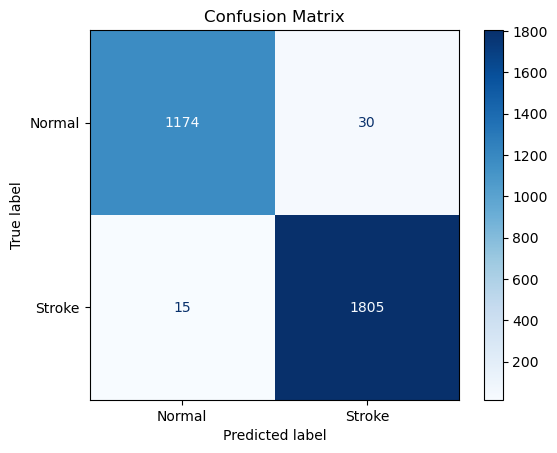

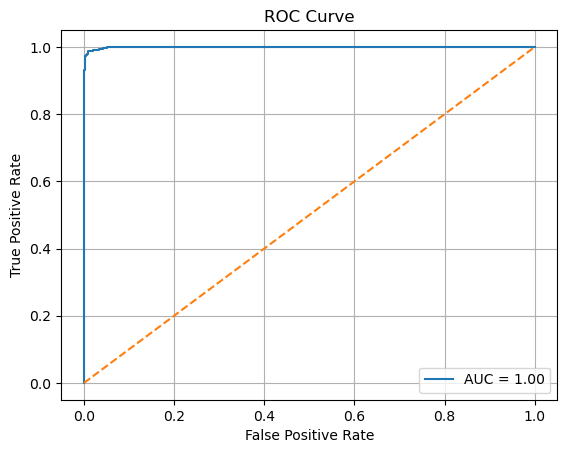

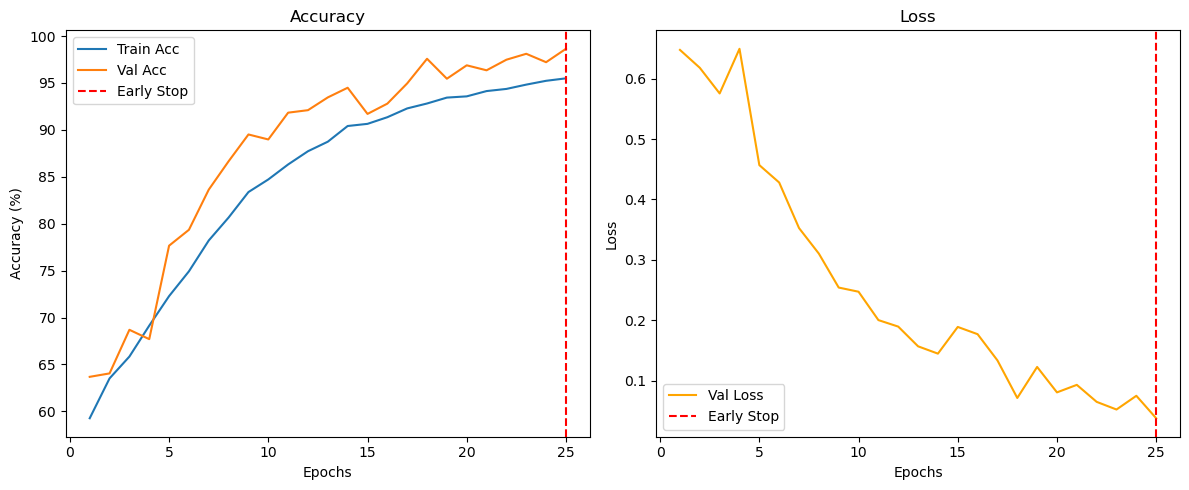

In [11]:
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pydicom
import cv2
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm import tqdm

# ============================
# 1. Dataset Splitter
# ============================
def split_dataset(dataset_path, output_path, train_ratio=0.8, val_ratio=0.1):
    categories = ["Stroke", "Normal"]
    for split in ["train", "val", "test"]:
        for category in categories:
            os.makedirs(os.path.join(output_path, split, category), exist_ok=True)

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path):
            print(f"❌ Error: Missing folder - {category_path}")
            continue
        images = [f for f in os.listdir(category_path) if f.endswith(".dcm")]
        random.shuffle(images)
        total = len(images)
        train_end = int(total * train_ratio)
        val_end = int(total * (train_ratio + val_ratio))
        splits = {
            "train": images[:train_end],
            "val": images[train_end:val_end],
            "test": images[val_end:]
        }
        for split, files in splits.items():
            for f in files:
                shutil.copy(os.path.join(category_path, f), os.path.join(output_path, split, category, f))
    print("✅ Dataset split complete.")

# ============================
# 2. DICOM Dataset Loader
# ============================
class DICOMDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        self.class_to_idx = {"Normal": 0, "Stroke": 1}
        for label in self.class_to_idx:
            class_dir = os.path.join(root_dir, label)
            for fname in os.listdir(class_dir):
                if fname.endswith(".dcm"):
                    self.samples.append((os.path.join(class_dir, fname), self.class_to_idx[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            dicom = pydicom.dcmread(path)
            img = dicom.pixel_array
            img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
            img = Image.fromarray(img).convert("L")
        except Exception as e:
            print(f"Error reading {path}: {e}")
            img = Image.fromarray(np.zeros((224, 224), dtype='uint8'))
        if self.transform:
            img = self.transform(img)
        return img, label

# ============================
# 3. Paths and Constants
# ============================
dataset_path = "dataset_2"
output_path = "split_dataset"
split_dataset(dataset_path, output_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 25
BATCH_SIZE = 16
LR = 1e-4
WEIGHT_DECAY = 1e-5
class_names = ["Normal", "Stroke"]

# ============================
# 4. Transforms
# ============================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(10, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ============================
# 5. Dataloaders
# ============================
train_dataset = DICOMDataset(root_dir=os.path.join(output_path, "train"), transform=transform_train)
val_dataset = DICOMDataset(root_dir=os.path.join(output_path, "val"), transform=transform_eval)
test_dataset = DICOMDataset(root_dir=os.path.join(output_path, "test"), transform=transform_eval)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ============================
# 6. ResNet-18 Model
# ============================
class ResNet(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(ResNet, self).__init__()
        from torchvision.models import resnet18, ResNet18_Weights
        weights = ResNet18_Weights.DEFAULT if pretrained else None
        self.model = resnet18(weights=weights)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

net = ResNet().to(device)

# ============================
# 7. Training Setup
# ============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

train_accuracies, val_accuracies, val_losses = [], [], []
best_val_acc = 0.0
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop_patience = 4

# ============================
# 8. Training Loop with Early Stopping
# ============================
print("Training ResNet-18 on DICOM data...")
for epoch in range(EPOCHS):
    net.train()
    total, correct, running_loss = 0, 0, 0.0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        train_loop.set_postfix(loss=running_loss / total, acc=100 * correct / total)

    train_acc = 100 * correct / total
    train_accuracies.append(train_acc)

    net.eval()
    val_correct, val_total, val_loss = 0, 0, 0.0
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}: ✅ Train Acc: {train_acc:.2f}% | ✅ Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(net.state_dict(), "best_stroke_detection_resnet18_2.pth")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"⏸️ No improvement for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= early_stop_patience:
        print("🛑 Early stopping triggered.")
        break

print(f"✅ Training complete. Best validation accuracy: {best_val_acc:.2f}%")

# ============================
# 9. Evaluation
# ============================
net.load_state_dict(torch.load("best_stroke_detection_resnet18_2.pth"))
net.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = net(images)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_prob.extend(probs[:, 1].cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ============================
# 10. AUC-ROC
# ============================
roc_auc = roc_auc_score(y_true, y_prob)
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# ============================
# 11. Plot Accuracy and Loss
# ============================
epochs_range = range(1, len(train_accuracies) + 1)
plt.figure(figsize=(12, 5))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Acc')
plt.plot(epochs_range, val_accuracies, label='Val Acc')
plt.axvline(len(train_accuracies), color='red', linestyle='--', label='Early Stop')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_losses, label='Val Loss', color='orange')
plt.axvline(len(train_accuracies), color='red', linestyle='--', label='Early Stop')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig("performance_graphs.png", dpi=300)
plt.show()
